<a href="https://colab.research.google.com/github/Ashish-Tripathy/cv_yantra_drishti/blob/master/1_CV_CIFAR_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import *
from keras.models import load_model
import cv2
import sys
from google.colab.patches import cv2_imshow
from google.colab import files

Using TensorFlow backend.


# Loading the Cifar Data

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


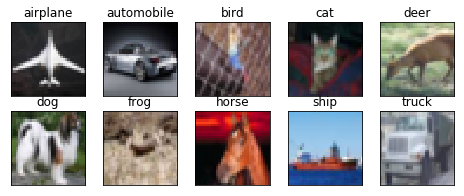

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# Data preprocessing

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Pretrained Resnet18 model

Using a model trained on ImageNet Keras to predict on Cifar-10 dataset

In [0]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-90nux6s9
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-90nux6s9
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-rof49mtn/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
from classification_models.resnet import ResNet18, preprocess_input

# prepare your data
X = train_features
y = train_labels

X = preprocess_input(X)
x_test = preprocess_input(test_features)
n_classes = 10 #number of classes to predict

# build model
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False) #call pretrained model with imagenet weights
x = Conv2D(10, kernel_size = (1,1),kernel_initializer="he_normal",  padding="same")(base_model.output)            #Pointwise convolution for getting the output channels            
x = GlobalAveragePooling2D()(x)                             #Introduced GAP to flatten the layer
output = Activation('softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])



W0630 11:45:25.589123 139972508292992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 11:45:25.634582 139972508292992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 11:45:25.635523 139972508292992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0630 11:45:25.638879 139972508292992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0630 11:45:25.641945 139972

44924928/44920640 [==============================] - 2s 0us/step


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
# train
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y,
          batch_size=64,
          epochs=10,
          validation_data=(x_test, test_labels),
          shuffle=True,verbose = 1) # train the model for 10 epochs

W0630 11:45:33.968643 139972508292992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0630 11:45:34.104636 139972508292992 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 30s 604us/step - loss: 1.0463 - acc: 0.6413 - val_loss: 0.7962 - val_acc: 0.7262
Epoch 2/10
50000/50000 [==============================] - 25s 498us/step - loss: 0.6518 - acc: 0.7719 - val_loss: 0.6958 - val_acc: 0.7611
Epoch 3/10
50000/50000 [==============================] - 25s 501us/step - loss: 0.5043 - acc: 0.8242 - val_loss: 0.6674 - val_acc: 0.7780
Epoch 4/10
50000/50000 [==============================] - 25s 503us/step - loss: 0.3967 - acc: 0.8620 - val_loss: 0.6928 - val_acc: 0.7788
Epoch 5/10
50000/50000 [==============================] - 25s 499us/step - loss: 0.3050 - acc: 0.8946 - val_loss: 0.6676 - val_acc: 0.7874
Epoch 6/10
50000/50000 [==============================] - 25s 500us/step - loss: 0.2312 - acc: 0.9196 - val_loss: 0.6988 - val_acc: 0.7947
Epoch 7/10
50000/50000 [==============================] - 25s 499us/step - loss: 0.1703 - acc: 0.9418 - val_loss: 0.

# GradCAM

## Defining functions for implementation

### Predicting on the image

In [0]:
def test_img_predict(img,img_num):
  class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
  preds = model.predict(img)
  actual_label = np.argmax(test_labels[img_num])
  class_idx = np.argmax(preds)
  class_output = model.output[:, class_idx]
  print("Original Class:",class_names[actual_label],";", "Predicted Class:",class_names[class_idx] )
  return class_output

To check the map for the top prediction, we take the topmost class index.

### Selecting the output from the final convolution layer and computing gradient with class output

In [0]:
def gradient_FeatureHeatMap(last_conv_name, class_output, channel_num,img_pr):
  last_conv_layer = model.get_layer(last_conv_name)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img_pr])
  for i in range(channel_num):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

We compute the gradient of the class output value with respect to the feature map. Then, we pool the gradients over all the axes leaving out the channel dimension. Finally, we weigh the output feature map with the computed gradient values. We also evaluate the heatmap by averaging the weighed feature map

### Defining the function to plot Gradient weighted Class Activation Map (GradCAM)

In [0]:
def plot_gradCAM(heatmap, img):  
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = np.uint8(255*img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0) 
  fig=plt.figure(figsize=(5, 5))
  ax1 = fig.add_subplot(2,2,1)
  ax1.set_title('Original')
  ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax2 = fig.add_subplot(2,2,2)
  ax2.set_title('GradCAM')
  ax2.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
  plt.show()
  return superimposed_img

Adds the heatmap with the image with more weights to image. A superimposed image is obtained which has brighter pixels where the activation happens

## Plotting GradCAM for a test image

A convolution from earlier stages are selected because RESNET18 has very large receptive field as much required for cifar-10, so earlier layers will show better results from gradcam than last layers

Original Class: automobile ; Predicted Class: automobile


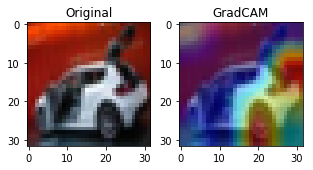

In [0]:
img = x_test[6,:,:] #selecting some random image by explicitly mentioning the image number
img_pr = np.expand_dims(img, axis=0)
class_output = test_img_predict(img_pr,6)
heatmap = gradient_FeatureHeatMap("stage2_unit1_conv1",class_output, 128,img_pr)
superimposed = plot_gradCAM(heatmap,img)


## Finding 50 Misclassified images from the model

In [0]:
#Predicting on the test images
Y_pred = model.predict(test_features)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([3, 8, 1, ..., 5, 1, 7])

In [0]:
y_test = np.argmax(test_labels, axis=1)
misclassified = []
for i in range(len(test_labels)):
  if(y_test[i]!=y_pred[i]):
    misclassified.append(i)
    if len(misclassified)==50:
      break


## Plotting and Downloading GradCam for the Misclassified images

Original Class: ship ; Predicted Class: automobile


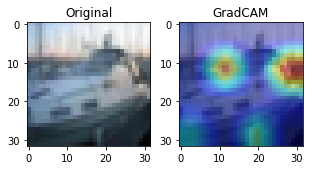

Original Class: dog ; Predicted Class: cat


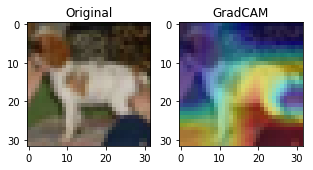

Original Class: horse ; Predicted Class: dog


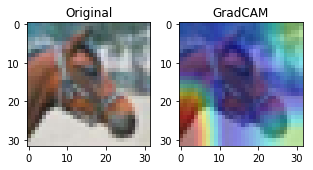

Original Class: horse ; Predicted Class: automobile


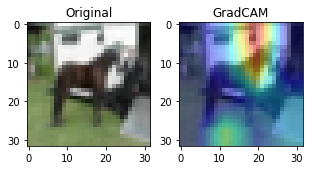

Original Class: dog ; Predicted Class: deer


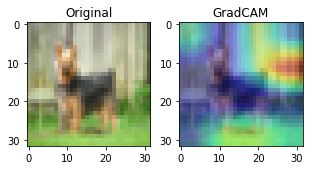

Original Class: bird ; Predicted Class: automobile


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


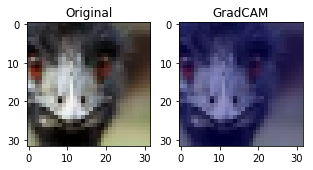

Original Class: dog ; Predicted Class: horse


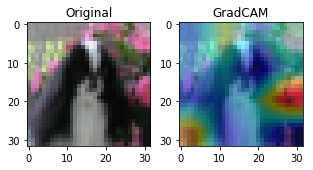

Original Class: truck ; Predicted Class: cat


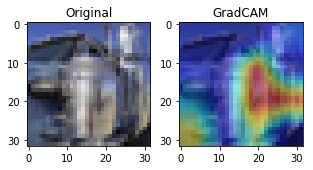

Original Class: horse ; Predicted Class: cat


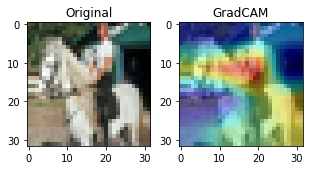

Original Class: horse ; Predicted Class: dog


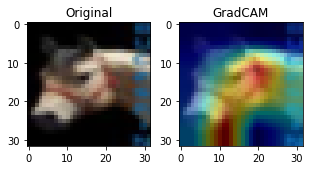

Original Class: deer ; Predicted Class: dog


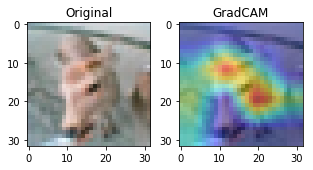

Original Class: frog ; Predicted Class: cat


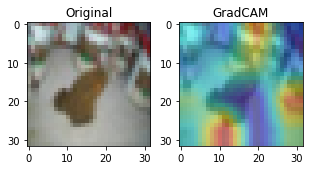

Original Class: cat ; Predicted Class: dog


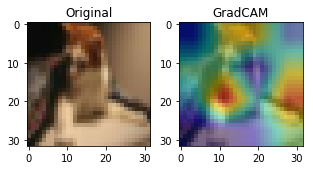

Original Class: airplane ; Predicted Class: truck


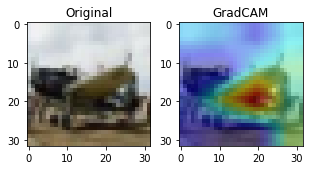

Original Class: cat ; Predicted Class: dog


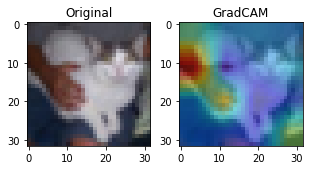

Original Class: cat ; Predicted Class: dog


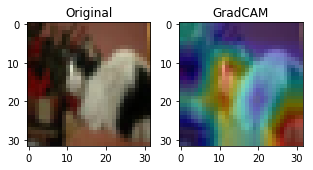

Original Class: dog ; Predicted Class: horse


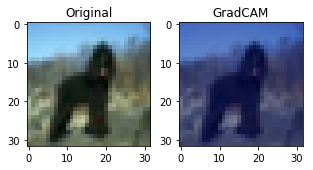

Original Class: bird ; Predicted Class: ship


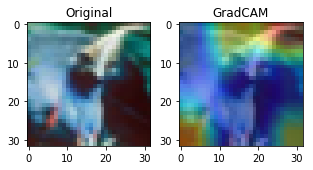

Original Class: horse ; Predicted Class: cat


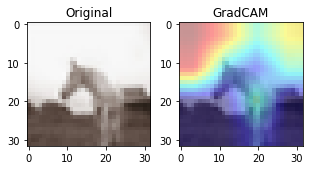

Original Class: cat ; Predicted Class: deer


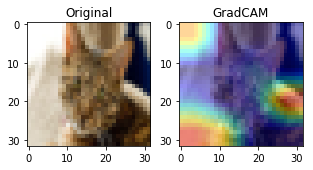

Original Class: frog ; Predicted Class: bird


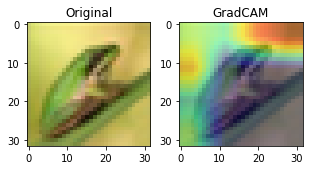

Original Class: bird ; Predicted Class: cat


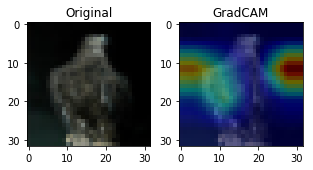

Original Class: airplane ; Predicted Class: bird


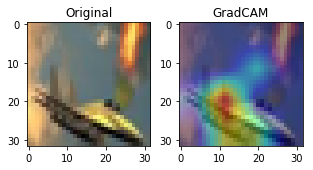

Original Class: dog ; Predicted Class: cat


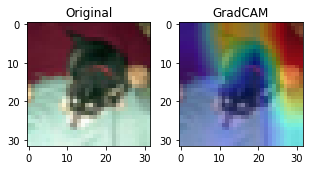

Original Class: bird ; Predicted Class: airplane


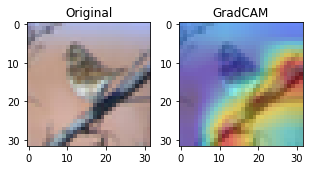

Original Class: bird ; Predicted Class: cat


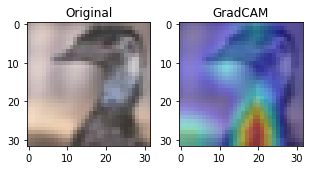

Original Class: bird ; Predicted Class: frog


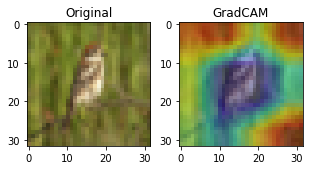

Original Class: truck ; Predicted Class: ship


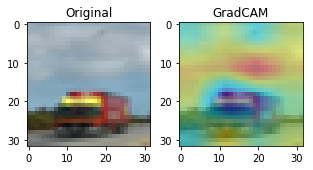

Original Class: bird ; Predicted Class: dog


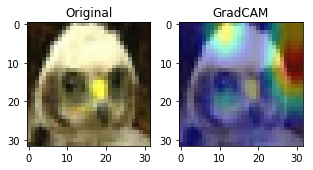

Original Class: airplane ; Predicted Class: horse


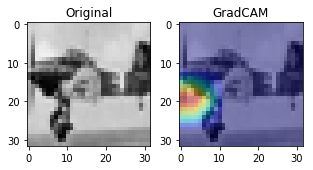

Original Class: dog ; Predicted Class: cat


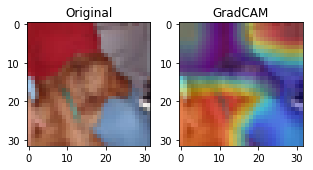

Original Class: ship ; Predicted Class: bird


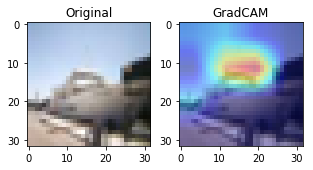

Original Class: deer ; Predicted Class: bird


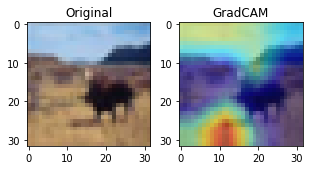

Original Class: dog ; Predicted Class: automobile


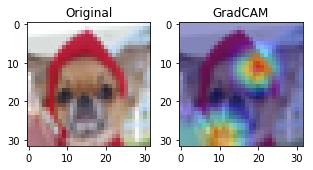

Original Class: truck ; Predicted Class: automobile


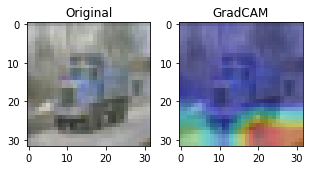

Original Class: cat ; Predicted Class: airplane


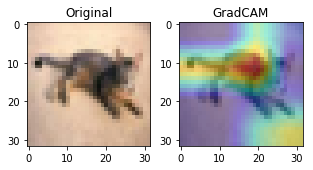

Original Class: deer ; Predicted Class: dog


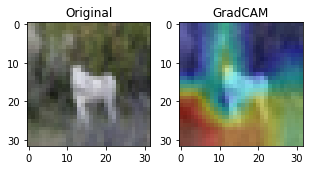

Original Class: cat ; Predicted Class: deer


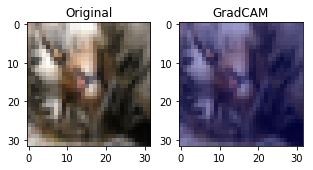

Original Class: truck ; Predicted Class: automobile


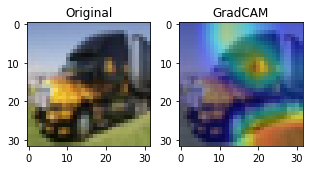

Original Class: frog ; Predicted Class: dog


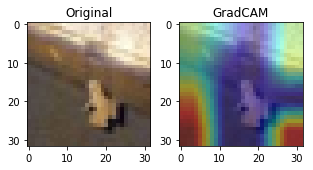

Original Class: horse ; Predicted Class: dog


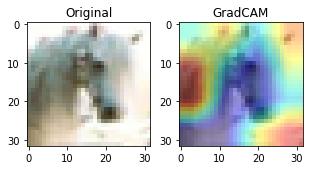

Original Class: dog ; Predicted Class: cat


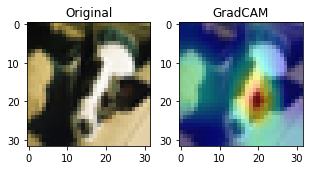

Original Class: ship ; Predicted Class: automobile


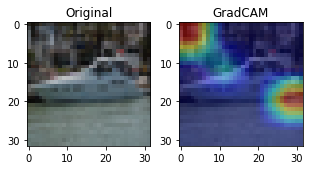

Original Class: airplane ; Predicted Class: truck


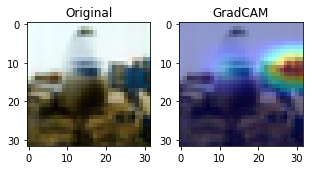

Original Class: truck ; Predicted Class: ship


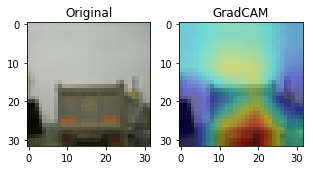

Original Class: bird ; Predicted Class: airplane


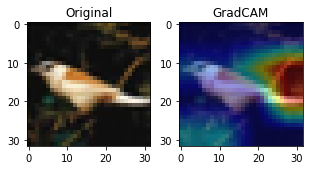

Original Class: deer ; Predicted Class: frog


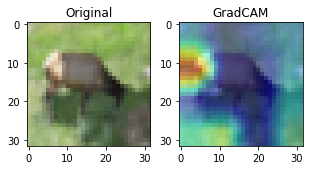

Original Class: cat ; Predicted Class: frog


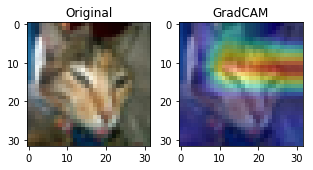

Original Class: airplane ; Predicted Class: bird


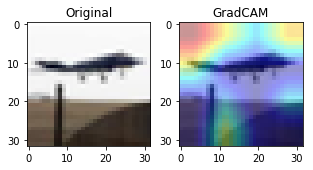

Original Class: dog ; Predicted Class: cat


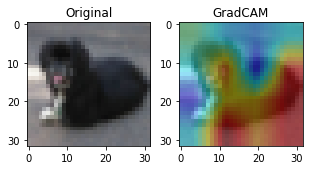

In [0]:
np.random.seed(123)
#np.random.seed(3)

for i in range(50):
  img_num = misclassified[i]
  img = test_features[img_num]
  img_pr = np.expand_dims(img, axis=0)
  class_output = test_img_predict(img_pr,img_num)
  heatmap = gradient_FeatureHeatMap("stage2_unit1_conv1",class_output, 128,img_pr)
  gradCam = plot_gradCAM(heatmap,img)
  image = 'misclass_'+str(misclassified[i])+'.png'
  plt.imsave(image,gradCam)
  files.download(image)
  